In [2]:
%reload_ext autoreload
%autoreload 2

from alpharaw.mzml import MzMLReader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from alphabase.spectral_library.base import SpecLibBase

In [3]:
root = Path("~//data/alphadia-validate/").expanduser()

data_folder = root / "data"
output_folder = root / "output"

#### Obtain raw & results data
Note: this is just required if you did not run the search yourself in search_1.10.0.ipynb

In [4]:
for folder in [data_folder, output_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Bulk injections of HeLa cell lysate acquired on the Orbitrap Astral
raw_data_url_list = [
    "https://datashare.biochem.mpg.de/s/339jg5HtGrwLwDN/download?files=20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_07.raw",
]

# results from search_1.10.0.ipynb
precursors_tsv_url = "https://datashare.biochem.mpg.de/s/fsCqlT757ttVWI8"
speclib_url = "https://datashare.biochem.mpg.de/s/VxakpS6mhM2IwxJ"


from alphadia.test_data_downloader import DataShareDownloader
raw_file_paths = [DataShareDownloader(url, data_folder).download() for url in raw_data_url_list]
precursors_tsv_path = DataShareDownloader(precursors_tsv_url, output_folder).download()
speclib_path = DataShareDownloader(speclib_url, output_folder).download()

C:\Users\alire\data\alphadia-validate\data\20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21min_F-40_07.raw already exists
C:\Users\alire\data\alphadia-validate\output\precursors.tsv already exists
C:\Users\alire\data\alphadia-validate\output\speclib.hdf already exists


### 1. Set up data
First we will point our notebook to the raw file and search results obtained using this raw file.

We will then load three objects into the notebook:
- The raw DIA data `dia_data`
- The search results `precursor_df`
- The spectral library `spectral_library`

In [5]:
current_raw_name = os.path.basename(raw_file_paths[0]).replace('.raw', '')
current_raw_path = raw_file_paths[0]

In [6]:
precursor_df = pd.read_csv(precursors_tsv_path, sep='\t')
precursor_df = precursor_df[precursor_df['run'] == current_raw_name]

spectral_library = SpecLibBase()
spectral_library.load_hdf(speclib_path)

In [7]:
from alphadia.data.alpharaw_wrapper import Thermo
dia_data =  Thermo(current_raw_path)

49it [00:08,  5.91it/s]


### 2. Inspect data
Next we want to inspect the data structures to get a better understanding of the data.

#### 2.1 Spectral library
We will start with the spectral library.
It's an alphabase SpecLibBase object, which contains the following attributes:
- `precursor_df`: a pandas DataFrame containing the precursor information
- `fragment_mz_df`: a pandas DataFrame containing the fragment m/z values
- `fragment_intensity_df`: a pandas DataFrame containing the fragment intensities

The `precursor_df` links to the fragment_mz_df and fragment_intensity_df via the `frag_start_idx` and `frag_stop_idx` columns.
For unique indexing we will use the `mod_seq_charge_hash` column.

In [8]:
spectral_library.precursor_df[['precursor_mz', 'sequence', 'mods', 'mod_sites', 'charge', 'mod_seq_charge_hash', 'frag_start_idx', 'frag_stop_idx']].head()

,precursor_mz,sequence,mods,mod_sites,charge,mod_seq_charge_hash,frag_start_idx,frag_stop_idx
0,474.764789,MIIWLEK,Oxidation@M,1,2,6778347273406786435,0,6
1,466.220746,FYSQQMK,,,2,15522010155980186642,6,12
2,409.218726,ADIEEIK,,,2,1205537395403030235,12,18
3,817.430175,ADIEEIK,,,1,1205537395403030234,18,24
4,451.215463,MFVSDFR,,,2,11088622922221221635,24,30


In [9]:
spectral_library.fragment_mz_df.head()

,b_z1,b_z2,y_z1,y_z2
0,148.042679,74.524979,801.486877,401.247101
1,261.126740,131.067001,688.402832,344.705048
2,374.210815,187.609039,575.318787,288.163025
3,560.290100,280.648682,389.239471,195.123367
4,673.374207,337.190735,276.155396,138.581329


In [10]:
spectral_library.fragment_intensity_df.head()

,b_z1,b_z2,y_z1,y_z2
0,0.000000,0.0,0.125327,0.000000
1,0.335304,0.0,1.000000,0.049048
2,0.282448,0.0,0.614709,0.001847
3,0.058418,0.0,0.219854,0.000000
4,0.024189,0.0,0.172246,0.000000


In [11]:
from alphabase.spectral_library.flat import SpecLibFlat
spectral_library_flat = SpecLibFlat()
spectral_library_flat.parse_base_library(spectral_library)
spectral_library_flat.fragment_df

,mz,intensity,type,loss_type,charge,number,position
0,801.486877,0.125327,121,0,1,6,0
1,261.126740,0.335304,98,0,1,2,1
2,688.402832,1.000000,121,0,1,5,1
3,344.705048,0.049048,121,0,2,5,1
4,374.210815,0.282448,98,0,1,3,2
...,...,...,...,...,...,...,...
5465187,630.320557,0.124205,121,0,1,6,44
5465188,573.299072,0.029776,121,0,1,5,45
5465189,444.256500,0.078959,121,0,1,4,46
5465190,343.208832,0.125994,121,0,1,3,47


| Column | Description |
|--------|-------------|
| mz | Mass to charge ratio of the fragment ion |
| intensity | Relative intensity of the fragment ion |
| type | Type of fragment series. Use `chr(type)` to get type:<br>`a = 97, b = 98, c = 99, x = 120, y = 121, z = 122` |
| loss_type | Fragment loss type:<br>`0 = none, 18 = H2O, 17 = NH3` |
| charge | Charge of the fragment ion |
| number | Fragment series number in direction of series (one indexed).<br>Example: `type=121` and `number=1` would be `y1` |
| position | Position of fragment ion from N-terminus (zero indexed).<br>Example: `type=98` and `position=2` would be `b3` |

#### 2.2 Precursor data

The identified precursors following search are stored in the `precursor_df` DataFrame.
The precursors in this dataframe come from the spectral library but have aditional information on their identification.

The most important columns are:
- `mod_seq_charge_hash`: the hash of the precursor sequence and charge

The scans where they were identified called frames.
- `frame_start`: the frame number of the first frame in the run.
- `frame_stop`: the frame number of the last frame in the run

Furthermore there is the q-value and a multitude of scores that were used to identify the precursor.

In [12]:
precursor_df.head()

,base_width_mobility,base_width_rt,rt_observed,mobility_observed,mono_ms1_intensity,top_ms1_intensity,sum_ms1_intensity,weighted_ms1_intensity,weighted_mass_deviation,weighted_mass_error,...,_candidate_idx,valid,candidate_idx,run,mod_seq_hash,mod_seq_charge_hash,pg_master,pg,pg_qval,intensity
0,0.0,20.185303,878.493469,0.000001,7.403505e+09,7.403505e+09,1.508568e+10,5.548682e+09,0.023692,0.023692,...,250551,True,250551,20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21m...,13886784644007243628,13886784644007243630,P62805,P62805,0.0,4.407890e+09
1,0.0,23.255554,685.877808,0.000001,1.020231e+10,1.020231e+10,1.767223e+10,7.734530e+09,-0.178309,0.178309,...,28615,True,28615,20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21m...,14751110910839796002,14751110910839796004,P62805,P62805,0.0,4.407890e+09
2,0.0,10.868530,207.885986,0.000001,1.231147e+06,1.231147e+06,2.963482e+06,9.690639e+05,1.002455,1.002455,...,430315,True,430315,20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21m...,8447969178672477057,8447969178672477059,P05198,P05198,0.0,8.145818e+07
3,0.0,32.611755,335.372009,0.000001,3.080493e+07,3.080493e+07,6.823846e+07,2.349190e+07,0.552120,0.552120,...,432992,True,432992,20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21m...,16672682504243237715,16672682504243237717,P24534,P24534,0.0,1.414546e+08
4,0.0,17.024841,489.280182,0.000001,5.295387e+09,5.295387e+09,9.861745e+09,4.008995e+09,0.433430,0.433430,...,94164,True,94164,20231017_OA2_TiHe_ADIAMA_HeLa_200ng_Evo011_21m...,12739187365774023873,12739187365774023875,P62805,P62805,0.0,4.407890e+09


#### 2.3 DIA data

Last, we have the raw DIA data objecrt loaded from the Thermo raw file.

This object contains all scans in the `dia_data.spectrum_df` DataFrame.
Each spectrum points to a collection of peak based on the `peak_start_idx` and `peak_stop_idx` columns.

These point to the `dia_data.peak_df` DataFrame, which contains the peak information.

In [13]:
dia_data.spectrum_df.head()

,spec_idx,peak_start_idx,peak_stop_idx,rt,precursor_mz,precursor_charge,isolation_lower_mz,isolation_upper_mz,ms_level,nce
0,0,0,35,0.000000,-1.00000,0,-1.000000,-1.000000,1,0.0
1,1,35,42,0.000439,385.42508,0,384.424625,386.425535,2,25.0
2,2,42,43,0.000521,389.42691,0,388.426455,390.427365,2,25.0
3,3,43,44,0.000601,395.42963,0,394.429175,396.430085,2,25.0
4,4,44,45,0.000694,397.43054,0,396.430085,398.430995,2,25.0


In [14]:
dia_data.peak_df.head()

,mz,intensity
0,459.638519,13105.375977
1,470.064972,10583.207031
2,472.338043,10462.697266
3,479.018433,10998.292969
4,507.042847,13371.034180


#### 3 Map precursor hit from search results to raw data

Using this information we can map the identified precursors to the raw data.

We will use the `get_library_entry_by_hash` function to get the library entry for a given hash.

This function returns the library entry, the fragment m/z values and the fragment intensities.



In [49]:
hash = precursor_df['mod_seq_charge_hash'].iloc[123]

def get_library_entry_by_hash(speclib, hash, min_intensity=0.01):
    speclib_entry = speclib.precursor_df[speclib.precursor_df['mod_seq_charge_hash'] == hash].iloc[0]

    fragment_mz = speclib.fragment_mz_df.iloc[speclib_entry.frag_start_idx:speclib_entry.frag_stop_idx].to_numpy().flatten()
    fragment_intensity = speclib.fragment_intensity_df.iloc[speclib_entry.frag_start_idx:speclib_entry.frag_stop_idx].to_numpy().flatten()
    fragment_mask = fragment_intensity > min_intensity

    fragment_mz = fragment_mz[fragment_mask]
    fragment_intensity = fragment_intensity[fragment_mask]

    # sort both by mz
    fragment_order = np.argsort(fragment_mz)
    fragment_mz = fragment_mz[fragment_order]
    fragment_intensity = fragment_intensity[fragment_order]

def get_flat_library_entry_by_hash(speclib_flat, hash, min_intensity=0.01):
    speclib_entry = speclib_flat.precursor_df[speclib_flat.precursor_df['mod_seq_charge_hash'] == hash].iloc[0]

    flat_frag_start_idx = speclib_entry.flat_frag_start_idx
    flat_frag_stop_idx = speclib_entry.flat_frag_stop_idx

    fragment_mz = speclib_flat.fragment_df['mz'].iloc[flat_frag_start_idx:flat_frag_stop_idx].to_numpy().flatten()
    fragment_intensity = speclib_flat.fragment_df['intensity'].iloc[flat_frag_start_idx:flat_frag_stop_idx].to_numpy().flatten()
    fragment_mask = fragment_intensity > min_intensity

    fragment_mz = fragment_mz[fragment_mask]
    fragment_intensity = fragment_intensity[fragment_mask]

    # sort both by mz
    fragment_order = np.argsort(fragment_mz)
    fragment_mz = fragment_mz[fragment_order]
    fragment_intensity = fragment_intensity[fragment_order]

    return speclib_entry, fragment_mz, fragment_intensity

speclib_entry, mz_library, intensity_library = get_flat_library_entry_by_hash(spectral_library_flat, hash)
precursor_entry = precursor_df[precursor_df['mod_seq_charge_hash'] == hash].iloc[0]

In [50]:
jit_data = dia_data.jitclass()

precursor_query = np.array([[speclib_entry.precursor_mz, speclib_entry.precursor_mz]], dtype=np.float32)
scan_limits = np.array([[precursor_entry.scan_start, precursor_entry.scan_stop, 1]], dtype=np.int64)
frame_limits = np.array([[precursor_entry.frame_start, precursor_entry.frame_stop, 1]], dtype=np.int64)

dense, precursor_index = jit_data.get_dense(
    frame_limits,
    scan_limits,
    mz_library,
    30,
    precursor_query,
)

#### 4 Visualize precursor data

Now, we want to viosualize the retrieved spectrum data.
We will start by visualizing the observed spectrum and the library spectrum.

The spectrum data `dense` is a 5 dimensional numpy array with a dense slice of the spectrum space.
The dimensions are:
- 0: either intensity information 0 or relative mass error 1
- 1: index of the fragment mz which was queried
- 2: ion mobility dimension (will be zero for DIA data)
- 3: The observations in the DIA cycle. As there might be multiple quadrupole windows where the precursor was detected, this will be a list of observations.
- 4: Retention time datapoints.

First we will select the intensity dimension and sum over all other dimensions but the fragment mz dimension.


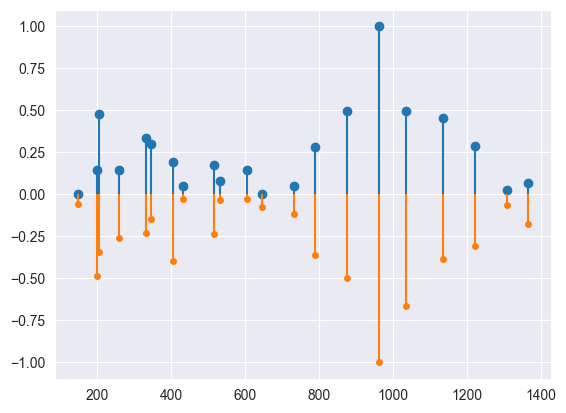

In [51]:
intensity_observed = dense[0].sum(axis=(1,2,3))
intensity_observed_normalized = intensity_observed / intensity_observed.max()
intensity_library_normalized = intensity_library / intensity_library.max()

plt.stem(mz_library, intensity_observed_normalized, markerfmt='o', basefmt=" ", linefmt='C0-')
plt.stem(mz_library, -intensity_library_normalized, markerfmt='o', basefmt=" ", linefmt='C1-')

plt.setp(plt.gca().lines[1::3], markersize=4)
plt.setp(plt.gca().lines[2::3], markersize=4)

plt.show()

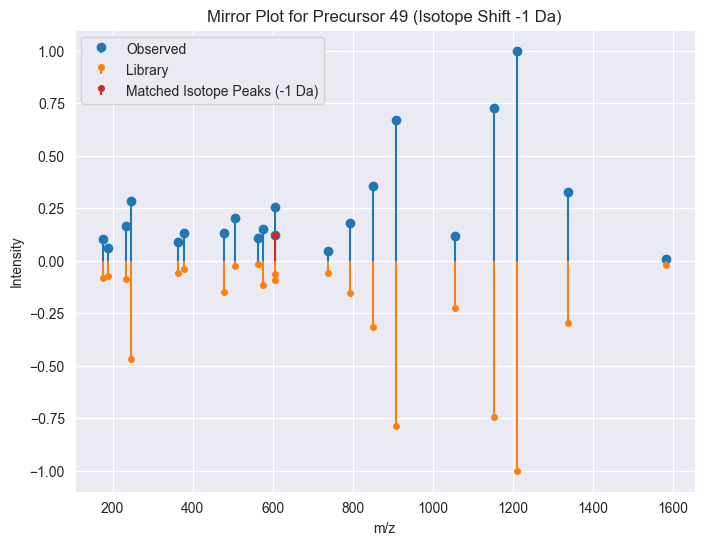

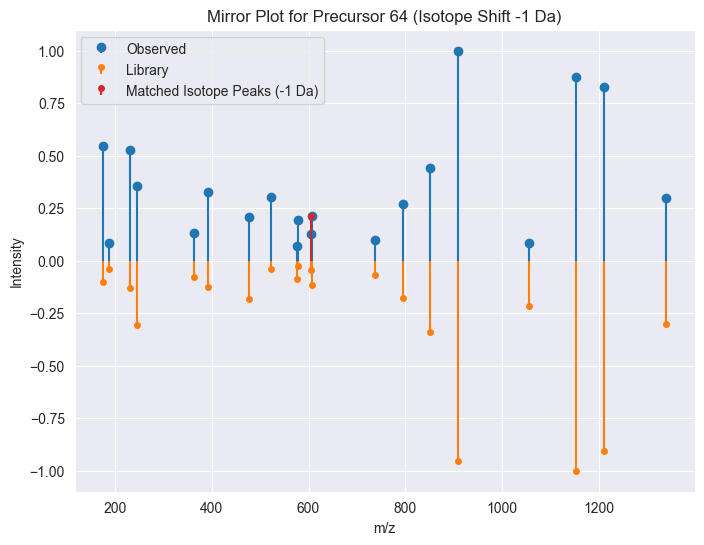

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def get_flat_library_entry_by_hash(speclib_flat, hash, min_intensity=0.01):
    speclib_entry = speclib_flat.precursor_df[speclib_flat.precursor_df['mod_seq_charge_hash'] == hash].iloc[0]
    flat_frag_start_idx = speclib_entry.flat_frag_start_idx
    flat_frag_stop_idx = speclib_entry.flat_frag_stop_idx

    fragment_mz = speclib_flat.fragment_df['mz'].iloc[flat_frag_start_idx:flat_frag_stop_idx].to_numpy().flatten()
    fragment_intensity = speclib_flat.fragment_df['intensity'].iloc[flat_frag_start_idx:flat_frag_stop_idx].to_numpy().flatten()

    fragment_mask = fragment_intensity > min_intensity
    fragment_mz = fragment_mz[fragment_mask]
    fragment_intensity = fragment_intensity[fragment_mask]

    fragment_order = np.argsort(fragment_mz)
    return speclib_entry, fragment_mz[fragment_order], fragment_intensity[fragment_order]

precursor_indices = np.arange( 100)
for idx in precursor_indices:
    hash = precursor_df['mod_seq_charge_hash'].iloc[idx]

    speclib_entry, mz_library, intensity_library = get_flat_library_entry_by_hash(spectral_library_flat, hash)
    precursor_entry = precursor_df[precursor_df['mod_seq_charge_hash'] == hash].iloc[0]

    precursor_query = np.array([[speclib_entry.precursor_mz, speclib_entry.precursor_mz]], dtype=np.float32)
    scan_limits = np.array([[precursor_entry.scan_start, precursor_entry.scan_stop, 1]], dtype=np.int64)
    frame_limits = np.array([[precursor_entry.frame_start, precursor_entry.frame_stop, 1]], dtype=np.int64)

    dense, precursor_index = jit_data.get_dense(
        frame_limits,
        scan_limits,
        mz_library,
        30,
        precursor_query,
    )

    intensity_observed = dense[0].sum(axis=(1,2,3))
    intensity_observed_normalized = intensity_observed / intensity_observed.max()
    intensity_library_normalized = intensity_library / intensity_library.max()

    mz_observed_shifted = mz_library - 1.003

    mz_tolerance = 0.01
    matched_mz_shifted = []
    matched_intensity_shifted = []

    for mz, intensity in zip(mz_observed_shifted, intensity_observed_normalized):
        if np.any(np.abs(mz_library - mz) < mz_tolerance):
            matched_mz_shifted.append(mz)
            matched_intensity_shifted.append(intensity)

    if matched_mz_shifted:
        plt.figure(figsize=(8, 6))
        plt.stem(mz_library, intensity_observed_normalized, markerfmt='o', basefmt=" ", linefmt='C0-', label="Observed")
        plt.stem(mz_library, -intensity_library_normalized, markerfmt='o', basefmt=" ", linefmt='C1-', label="Library")
        plt.stem(matched_mz_shifted, matched_intensity_shifted, markerfmt='o', basefmt=" ", linefmt='C3-', label="Matched Isotope Peaks (-1 Da)")

        plt.setp(plt.gca().lines[1::3], markersize=4)
        plt.setp(plt.gca().lines[2::3], markersize=4)
        plt.setp(plt.gca().lines[3::3], markersize=4)

        plt.xlabel("m/z")
        plt.ylabel("Intensity")
        plt.title(f"Mirror Plot for Precursor {idx} (Isotope Shift -1 Da)")
        plt.legend()
        plt.show()


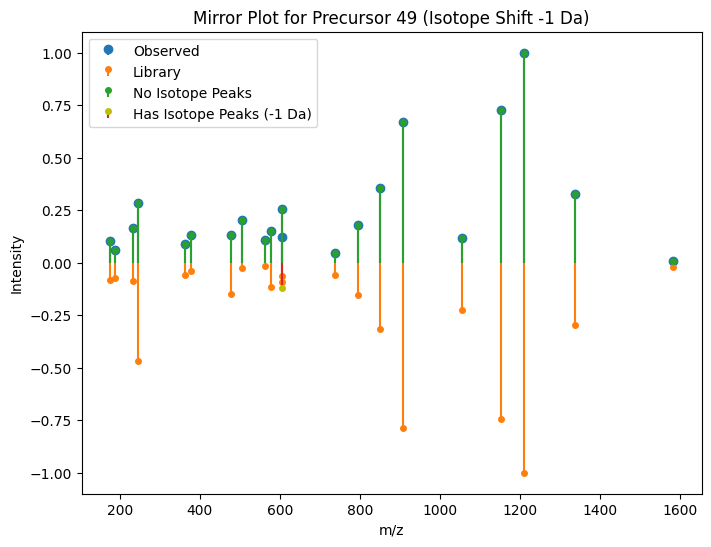

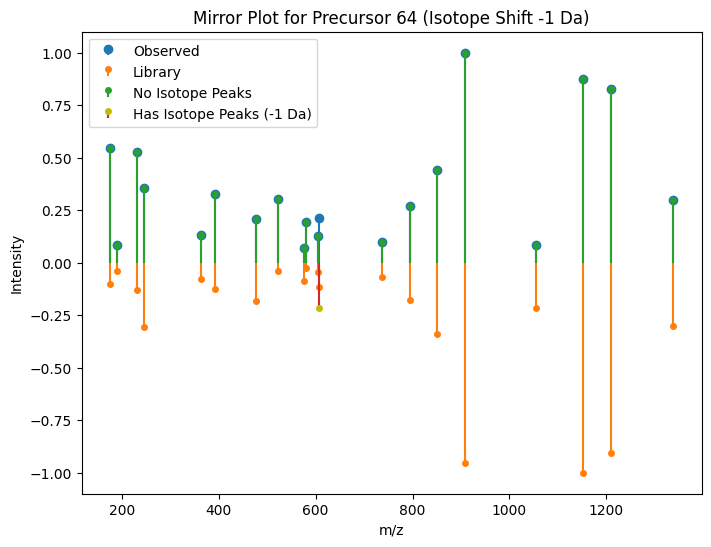

In [101]:
import numpy as np
import matplotlib.pyplot as plt

def categorize_peaks(mz_library, intensity_observed_normalized, mz_tolerance=0.01):

    mz_observed_shifted = mz_library - 1.003

    no_isotope_mz = []
    no_isotope_intensity = []
    isotope_mz = []
    isotope_intensity = []

    for mz, intensity in zip(mz_library, intensity_observed_normalized):

        if np.any(np.abs(mz_library - mz_observed_shifted) < mz_tolerance):
            isotope_mz.append(mz)
            isotope_intensity.append(intensity)
        else:
            no_isotope_mz.append(mz)
            no_isotope_intensity.append(intensity)

    return no_isotope_mz, no_isotope_intensity, isotope_mz, isotope_intensity

precursor_indices = np.arange(100)

for idx in precursor_indices:
    hash = precursor_df['mod_seq_charge_hash'].iloc[idx]

    speclib_entry, mz_library, intensity_library = get_flat_library_entry_by_hash(spectral_library_flat, hash)
    precursor_entry = precursor_df[precursor_df['mod_seq_charge_hash'] == hash].iloc[0]

    precursor_query = np.array([[speclib_entry.precursor_mz, speclib_entry.precursor_mz]], dtype=np.float32)
    scan_limits = np.array([[precursor_entry.scan_start, precursor_entry.scan_stop, 1]], dtype=np.int64)
    frame_limits = np.array([[precursor_entry.frame_start, precursor_entry.frame_stop, 1]], dtype=np.int64)

    dense, precursor_index = jit_data.get_dense(
        frame_limits,
        scan_limits,
        mz_library,
        30,
        precursor_query,
    )

    intensity_observed = dense[0].sum(axis=(1,2,3))
    if intensity_observed.max() == 0:
        continue

    intensity_observed_normalized = intensity_observed / intensity_observed.max()
    intensity_library_normalized = intensity_library / intensity_library.max()

    no_isotope_mz, no_isotope_intensity, isotope_mz, isotope_intensity = categorize_peaks(
        mz_library, intensity_observed_normalized
    )

    if isotope_mz:
        plt.figure(figsize=(8, 6))

        plt.stem(mz_library, intensity_observed_normalized, markerfmt='o', basefmt=" ", linefmt='C0-', label="Observed")

        plt.stem(mz_library, -intensity_library_normalized, markerfmt='o', basefmt=" ", linefmt='C1-', label="Library")

        if no_isotope_mz:
            plt.stem(no_isotope_mz, no_isotope_intensity, markerfmt='o', basefmt=" ", linefmt='C2-', label="No Isotope Peaks")

        plt.stem(isotope_mz, -np.array(isotope_intensity), markerfmt='yo', basefmt=" ", linefmt='C3-', label="Has Isotope Peaks (-1 Da)")

        plt.setp(plt.gca().lines[1::4], markersize=4)
        plt.setp(plt.gca().lines[2::4], markersize=4)
        if no_isotope_mz:
            plt.setp(plt.gca().lines[3::4], markersize=4)
        plt.setp(plt.gca().lines[4::4], markersize=4)

        plt.xlabel("m/z")
        plt.ylabel("Intensity")
        plt.title(f"Mirror Plot for Precursor {idx} (Isotope Shift -1 Da)")
        plt.legend()

        plt.show()


|Finally, we will visualize the Precusor ion chromatogram.
We will again select the intensity dimension and sum over ion mobility and observation but leave the retention time dimension.


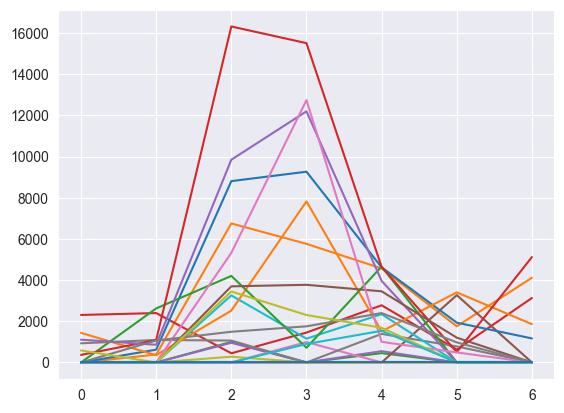

In [18]:
xic_observed = dense[0].sum(axis=(1,2))
for i in range(xic_observed.shape[0]):
    plt.plot(xic_observed[i])
plt.show()